In [1]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import torchaudio
import IPython.display as ipd
import torch
import torchaudio
from encodec import EncodecModel
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from tqdm import  tqdm
from torchvision import transforms
from IPython.display import FileLink


In [2]:
channel_means = [  2.2741,  11.2872,  -3.3938,  -1.5556,  -0.0302,   7.6089,  -5.5797,
          0.2140,  -0.3536,   6.0188,   1.8582,  -0.1103,   2.2026,  -7.0081,
         -0.0721,  -8.7742,  -2.4182,   4.4447,  -0.2184,  -0.5209, -11.9494,
         -4.0776,  -1.4555,  -1.6505,   6.4522,   0.0997,  10.4067,  -3.9268,
         -7.0161,  -3.1253,  -8.5145,   3.1156,   2.2279,  -5.2728,   2.8541,
         -3.3980,  -1.1775,  -9.7662,   0.3048,   3.8765,   4.5021,   2.6239,
         14.1057,   3.2852,   1.9702,  -1.6345,  -4.3733,   3.8198,   1.1421,
         -4.4388,  -5.3498,  -6.6044,  -0.4426,   2.8000,  -7.0858,   2.4989,
         -1.4915,  -6.1275,  -3.0896,   1.1227,  -8.7984,  -4.9831,  -0.3888,
         -3.1017,  -7.5745,  -2.4760,   1.0540,  -2.5350,   0.0999,   0.6126,
         -1.2301,  -5.8328,  -0.7275,  -1.2316,  -2.2532, -11.5017,   0.9166,
         -2.2268,  -2.8496,  -0.5093,  -0.3037,  -6.3689,  -9.5225,   4.5965,
          3.1329,  -1.8315,   5.3135,  -3.8361,   1.6335,  -0.1705,  11.0513,
          5.3907,  -0.2660,   4.6109,  -8.9019,   6.5515,   0.8596,  16.6196,
         -0.7732,   4.1237,   2.9267,   9.9652,   4.6615,   1.4660,  -9.7225,
         -1.5841,  -0.5714,  -4.3343,  -0.1914,   2.8624, -11.2139,  -2.5840,
         -6.7120,   0.2601,  -5.4195,   0.3554,   3.0438,  -1.0295,   1.3360,
         -4.1767,   0.6468,   1.8145,   1.7140,   3.0185,   0.4881,   0.5796,
         -2.4755,   2.6202]
channel_stds = [1.7524, 1.2040, 1.1098, 1.1021, 1.3688, 1.1374, 1.8660, 0.9791, 1.4331,
        1.7740, 1.2690, 1.0297, 0.9953, 1.5363, 1.2166, 1.6564, 1.4858, 1.2349,
        1.5086, 1.0814, 1.4421, 0.9258, 0.9343, 1.2007, 1.3848, 1.2732, 1.7759,
        1.3544, 1.4707, 1.2685, 1.7004, 1.2947, 1.2967, 1.8925, 0.9231, 0.7637,
        1.3777, 1.6680, 0.9658, 0.9257, 0.5259, 0.9949, 1.7375, 1.0734, 1.2916,
        0.8570, 0.6263, 0.9911, 0.9574, 0.9979, 1.5969, 1.1886, 1.1147, 1.2280,
        2.0169, 1.1813, 1.2589, 1.1162, 1.3689, 1.2516, 1.2139, 1.0343, 1.1895,
        1.1726, 1.1923, 1.2714, 1.0043, 0.6465, 1.3860, 1.4449, 0.9567, 1.0218,
        0.9560, 1.4757, 1.0544, 0.8112, 1.4364, 1.0843, 1.2569, 1.0138, 1.1886,
        0.8627, 1.1016, 1.4231, 1.3607, 1.1215, 1.9759, 1.5381, 0.9219, 0.8572,
        0.6288, 0.8029, 1.1699, 1.1962, 1.5783, 0.9037, 1.2214, 2.0878, 1.3015,
        1.2254, 1.2898, 1.5421, 1.2834, 1.7237, 1.3471, 0.8689, 1.2807, 1.2174,
        1.2048, 0.6644, 1.5379, 1.4997, 0.7932, 0.7638, 0.8680, 1.3108, 1.8261,
        1.3964, 1.2147, 1.1391, 1.0011, 1.5988, 1.5721, 1.0963, 1.4303, 1.3737,
        1.5043, 1.3079]


def show_split_img(image, title=None):
    # Split the image in half horizontally
    height, width = image.shape
    half_width = width // 2
    left_half = image[:, :half_width]
    right_half = image[:, half_width:]

    # Create the subplots and plot the left and right halves of the image
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 2))
    

    axs[0].imshow(left_half)
    axs[1].imshow(right_half)
    # Hide the x and y axis ticks and labels for a cleaner plot
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Show the plot
    # if (title):
    #     axs[0].title(title)
    plt.savefig('sample')

    plt.show()
    plt.close()

    
def rescale(image):
    image = torch.Tensor.view(image, [128, 24, 21]).clone()
    mean_v = torch.tensor(channel_means)
    std_v =torch.tensor(channel_stds)
    image = image * std_v.view(-1,1,1) + mean_v.view(-1,1,1)
    
    # image = (image * channel_stds[:, None, None]) + channel_means[:, None, None]
    
    
#     for row, mean, std in zip(image, channel_means, channel_stds):
#         row = row * std + mean
    
    image = torch.Tensor.view(image, [1, 128, 504])
    return image

def visualize_channels(img):
    test_img = img.clone()
    test_img = torch.Tensor.view(test_img, [128, 24, 21])
    fig, axs = plt.subplots(8, 16, figsize=(12, 12))
    for ax, layer in zip(axs.flatten(), test_img):
        ax.imshow(layer.cpu().numpy())
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])



In [3]:
def show_split_img(image, title=None):
    # Split the image in half horizontally
    height, width = image.shape
    half_width = width // 2
    left_half = image[:, :half_width]
    right_half = image[:, half_width:]

    # Create the subplots and plot the left and right halves of the image
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 2))
    axs[0].imshow(left_half)
    axs[1].imshow(right_half)

    # Hide the x and y axis ticks and labels for a cleaner plot
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Show the plot
    # if (title):
    #     axs[0].title(title)
    plt.show()

In [50]:
device = 'cuda'

In [51]:
# l_folder = "/u/li19/data_folder/AudioTaggingDoneRight/egs/audioset/data/datafiles/bal_latent_raw"
pregen_latent_folder = "/u/li19/data_folder/AudioTaggingDoneRight/egs/audioset/data/datafiles/unbal_latent_raw"

model = EncodecModel.encodec_model_24khz()
model.set_target_bandwidth(6.0)
model = model.to(device)

In [52]:
train_data_path = "/u/li19/data_folder/AudioTaggingDoneRight/egs/audioset/data/datafiles/alpaca_bal_unbal.json"
with open(train_data_path, 'r') as f:
    train_data = json.load(f)["data"]

In [53]:
train_data_dic = {}
for i,entry in enumerate(train_data):
    youtube_id = entry['wav'].split('.')[0][-11:]
    train_data_dic[youtube_id] = entry


In [107]:
keyword = 'bark'

In [108]:
for i,entry in enumerate(train_data):
    # if i> 200:
    #     break
    youtube_id = entry['wav'].split('.')[0][-11:]
    if keyword in [ent.lower() for ent in entry['classes']]:
        print(youtube_id, entry['classes'], entry['caption'])


-1KAjPp2-Vc ['Bark', 'Domestic animals, pets', 'Howl', 'Yip', 'Speech', 'Dog', 'Animal']  a family is walking by their domestic animals while they bark, howl, and yip. The parents are speaking while the dog is barking and the animals are purring, whimpering, and barking. 
-37X0bRVT0g ['Bark', 'Domestic animals, pets', 'Yip', 'Dog', 'Animal']  a domestic family is walking in the park with animals of all kinds.  A dog barking and other animals making similar sounds can be heard. 
-49HTaaNAjk ['Bark', 'Domestic animals, pets', 'Speech', 'Dog', 'Animal']  a person is talking to a dog in the middle of a domestic yard with other animals like cats, birds and insects.
-5rnGk2e1ao ['Bark', 'Domestic animals, pets', 'Bow-wow', 'Dog', 'Animal']  a family is walking in the park while being surrounded by domestic animals such as dogs, cats, and birds chirping.
-7T1vQ2CgdQ ['Bark', 'Domestic animals, pets', 'Alarm', 'Dog', 'Animal']  a person is walking near their domestic animals (pets) that includ

In [110]:
sample_youtube_id = '-5rnGk2e1ao'


In [111]:
train_data_dic[sample_youtube_id]

{'wav': '/u/li19/data_folder/audioSetAudio/unbalanced_wav/-5rnGk2e1ao.wav',
 'labels': '/m/05tny_,/m/068hy,/m/07rc7d9,/m/0bt9lr,/m/0jbk',
 'caption': ' a family is walking in the park while being surrounded by domestic animals such as dogs, cats, and birds chirping.',
 'classes': ['Bark', 'Domestic animals, pets', 'Bow-wow', 'Dog', 'Animal']}

In [112]:
youtube_id = sample_youtube_id
pregen_latent_path = os.path.join(pregen_latent_folder , youtube_id+'.npy')
codebook_dirc_load = np.load(pregen_latent_path )
wav_folder = "/u/li19/data_folder/audioSetAudio/unbalanced_wav"
wav, sr = torchaudio.load(os.path.join(wav_folder, youtube_id+'.wav'))
wav = wav - wav.mean()
wav=wav.to(device)
print(wav.shape)

torch.Size([1, 160000])


In [113]:
t_latent = torch.from_numpy(codebook_dirc_load[None, :, :])
t_latent = t_latent.to(device)

post_quant = model.quantizer.decode(t_latent.transpose(0,1).to(dtype=torch.int32))

post_quant.shape

torch.Size([1, 128, 504])

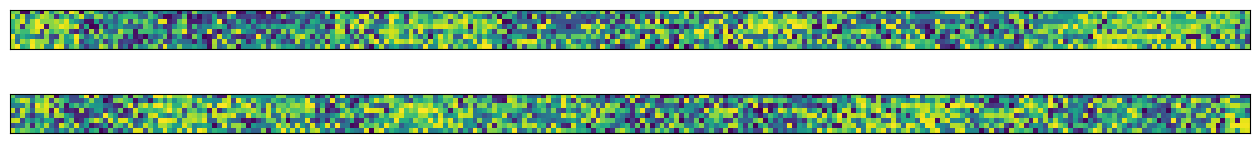

In [114]:
show_split_img(codebook_dirc_load)
ipd.Audio(wav.cpu(), rate=sr)

In [115]:
m = torch.nn.ConstantPad1d((0, 1_000), 0)    
wav_padded = m(wav)

real_encoder_latent = model.encoder(wav_padded[None, :, :])
print(real_encoder_latent.shape)

torch.Size([1, 128, 504])


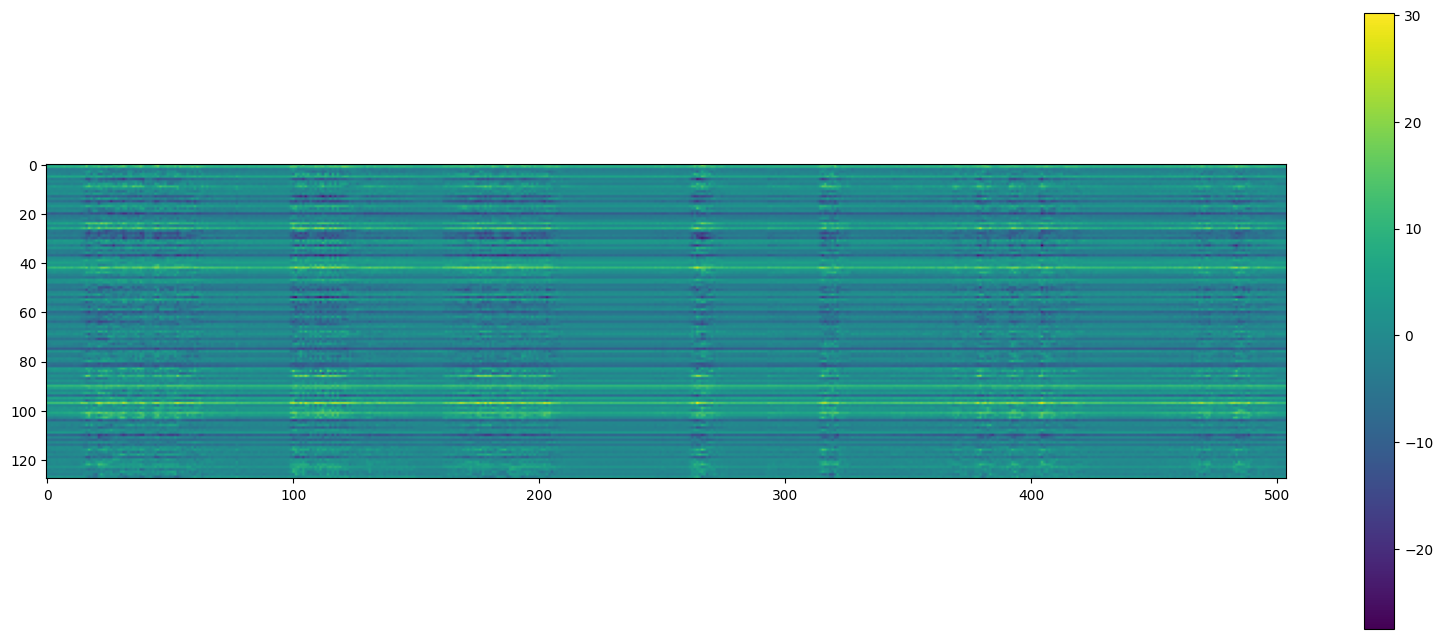

/u/li19/diffusers_with_dataloader/notebooks/imgs/endcoder_latent--5rnGk2e1ao.png

min val:-27.509296417236328
max val:30.203044891357422
mean:-0.498193621635437
std:5.379598617553711


In [116]:
# print(real_latent)
plt.figure(figsize=(20,8))
plt.imshow(real_encoder_latent.detach().cpu().numpy()[0])
filename = f'imgs/endcoder_latent-{youtube_id}.png'
plt.savefig(filename)
plt.colorbar()

plt.show()
plt.close()
display(FileLink(filename))
print(f'min val:{real_encoder_latent.detach().cpu().numpy()[0].min()}')
print(f'max val:{real_encoder_latent.detach().cpu().numpy()[0].max()}')

print(f'mean:{real_encoder_latent.detach().cpu().numpy()[0].mean()}')
print(f'std:{real_encoder_latent.detach().cpu().numpy()[0].std()}')

In [117]:
transformed_real_encoder_latent = torch.Tensor.view(real_encoder_latent, [1, 128, 24, 21])

transform = transforms.Compose([
            transforms.Normalize(channel_means, channel_stds)
        ])
norm_encoder_latent = transform(transformed_real_encoder_latent)
norm_encoder_latent = torch.Tensor.view(norm_encoder_latent, [1, 128, 504])

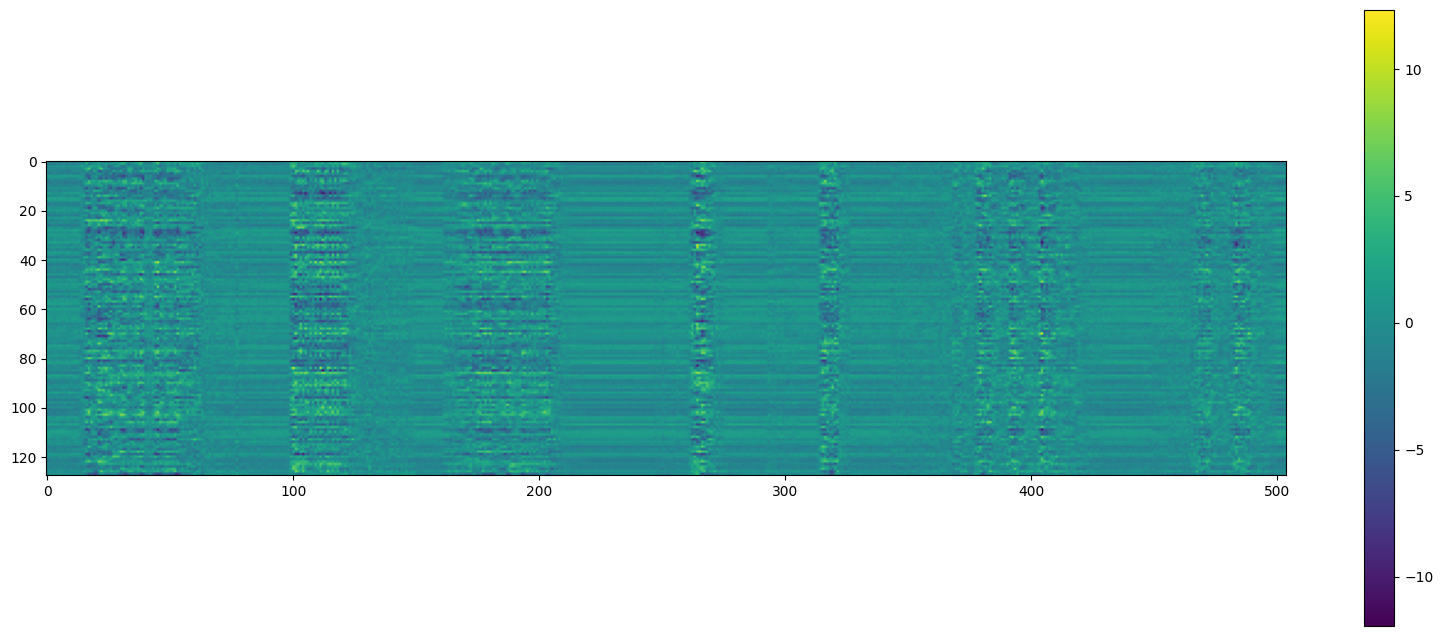

/u/li19/diffusers_with_dataloader/notebooks/imgs/norm_encoder_latent_-5rnGk2e1ao.png

min val:-11.943565368652344
max val:12.326349258422852
mean:0.012202310375869274
std:1.774339199066162


In [118]:
plt.figure(figsize=(20,8))
plt.imshow(norm_encoder_latent.detach().cpu().numpy()[0])
filename = f'imgs/norm_encoder_latent_{youtube_id}.png'

plt.savefig(filename)
plt.colorbar()
plt.show()
plt.close()
display(FileLink(filename))
print(f'min val:{norm_encoder_latent.detach().cpu().numpy()[0].min()}')
print(f'max val:{norm_encoder_latent.detach().cpu().numpy()[0].max()}')

print(f'mean:{norm_encoder_latent.detach().cpu().numpy()[0].mean()}')
print(f'std:{norm_encoder_latent.detach().cpu().numpy()[0].std()}')

In [119]:
rescale_enc_latent = rescale(norm_encoder_latent.detach().cpu())

In [120]:
# mean = -0.50601
# std = 5.22701

# scale_latent = real_latent.clone()

# print(scale_latent.mean())
# print(scale_latent.std())

# scale_latent /= std
# scale_latent += mean

# print("==== POST SCALE ====")
# print(scale_latent.mean())
# print(scale_latent.std())

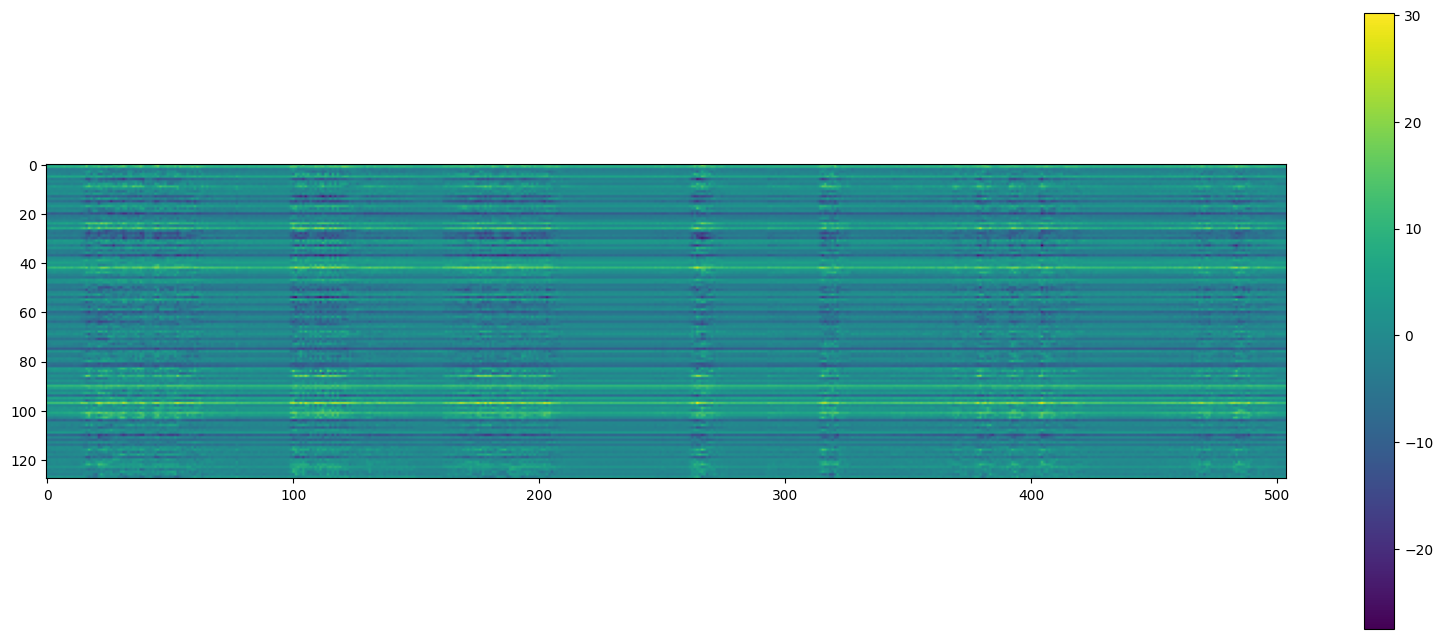

/u/li19/diffusers_with_dataloader/notebooks/imgs/rescaleEnc_latent_-5rnGk2e1ao.png

min val:-27.509296417236328
max val:30.203044891357422
mean:-0.498193621635437
std:5.379598617553711


In [121]:
plt.figure(figsize=(20,8))
plt.imshow(rescale_enc_latent.detach().numpy()[0])
filename = f'imgs/rescaleEnc_latent_{youtube_id}.png'
plt.savefig(filename)
plt.colorbar()
plt.show()
plt.close()
display(FileLink(filename))
print(f'min val:{rescale_enc_latent.detach().numpy()[0].min()}')
print(f'max val:{rescale_enc_latent.detach().numpy()[0].max()}')

print(f'mean:{rescale_enc_latent.detach().numpy()[0].mean()}')
print(f'std:{rescale_enc_latent.detach().numpy()[0].std()}')

In [122]:
scale_diff = rescale_enc_latent.to(device)-real_encoder_latent.to(device)
print(scale_diff.sum(dim=0))

tensor([[-1.1921e-07, -4.4703e-08,  0.0000e+00,  ...,  0.0000e+00,
         -1.1921e-07,  5.9605e-08],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 5.9605e-08,  0.0000e+00,  0.0000e+00,  ..., -5.9605e-08,
         -5.9605e-08, -5.9605e-08],
        [ 1.1921e-07,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          1.1921e-07,  0.0000e+00]], device='cuda:0', grad_fn=<SumBackward1>)


In [123]:
# regen_scale = model.decoder(scale_latent)[0][0].detach().numpy()
# regen_real = model.decoder(real_latent)[0][0].detach().numpy()

torch.Size([1, 161000])
torch.Size([1, 160000])
cuda:0 cuda:0 cpu


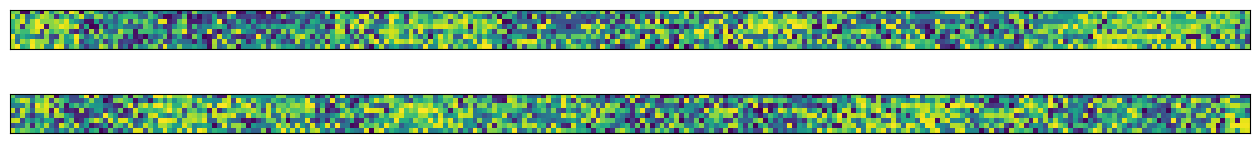

diff:<class 'torch.Tensor'>,tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


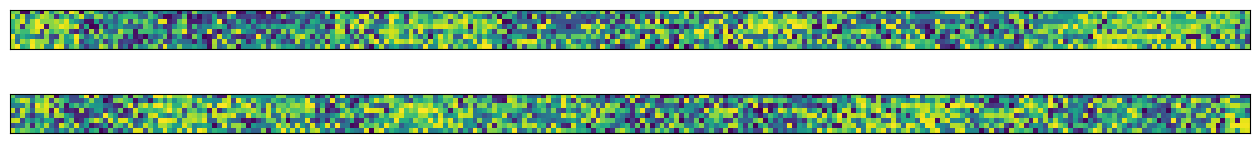

pre_decode shape: torch.Size([1, 128, 504])


In [166]:
print(wav_padded.shape)
# m = torch.nn.ConstantPad1d((0, 1_000), 0)    
# wav = m(wav)# ext_wav = m(wav)
pre_post_flag = 'pre'
ext_wav = wav
print(ext_wav.shape)
latent, scale = model.encode(wav_padded[None, :, :])[0]
print(latent.device, t_latent.device, rescale_enc_latent.device)
show_split_img(codebook_dirc_load)
# diff = latent-codebook_dirc_load
diff = latent-t_latent
print(f'diff:{type(diff)},{torch.sum(diff, dim=1)}')
print(latent.shape)
show_split_img(latent[0].cpu())
# unet used to be here
pre_decode = model.quantizer.decode(latent.transpose(0,1))
# unet should be here
print(f'pre_decode shape: {pre_decode.shape}')
if pre_post_flag == 'pre':
# final = model.decoder(pre_decode.to(device))
    final = model.decoder(real_encoder_latent.to(device))
else:
    final = model.decoder(pre_decode.to(device))
final = final.detach().cpu().numpy()[0][0]

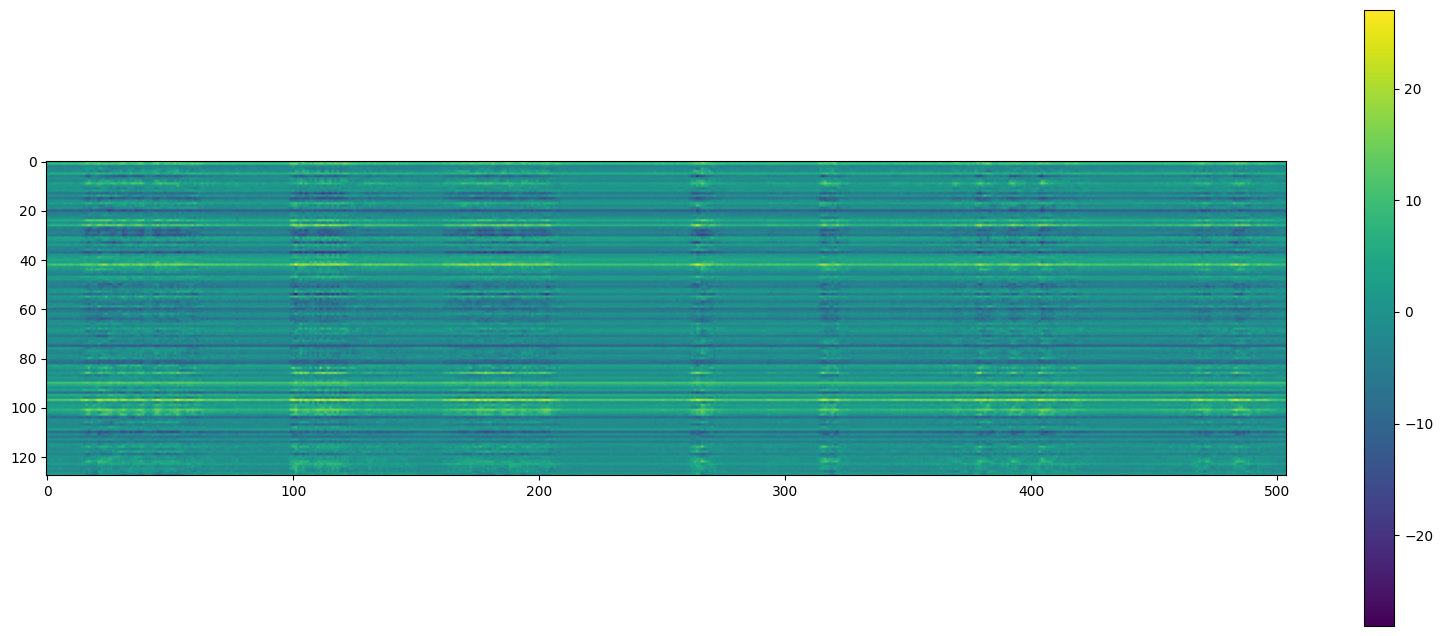

/u/li19/diffusers_with_dataloader/notebooks/imgs/decoder_latent--5rnGk2e1ao.png

min val:-28.132347106933594
max val:27.05057716369629
mean:-0.4929136037826538
std:5.296686172485352


In [167]:
# print(real_latent)
plt.figure(figsize=(20,8))
plt.imshow(pre_decode.detach().cpu().numpy()[0])
filename = f'imgs/decoder_latent-{youtube_id}.png'
plt.savefig(filename)
plt.colorbar()

plt.show()
plt.close()
display(FileLink(filename))
print(f'min val:{pre_decode.detach().cpu().numpy()[0].min()}')
print(f'max val:{pre_decode.detach().cpu().numpy()[0].max()}')

print(f'mean:{pre_decode.detach().cpu().numpy()[0].mean()}')
print(f'std:{pre_decode.detach().cpu().numpy()[0].std()}')

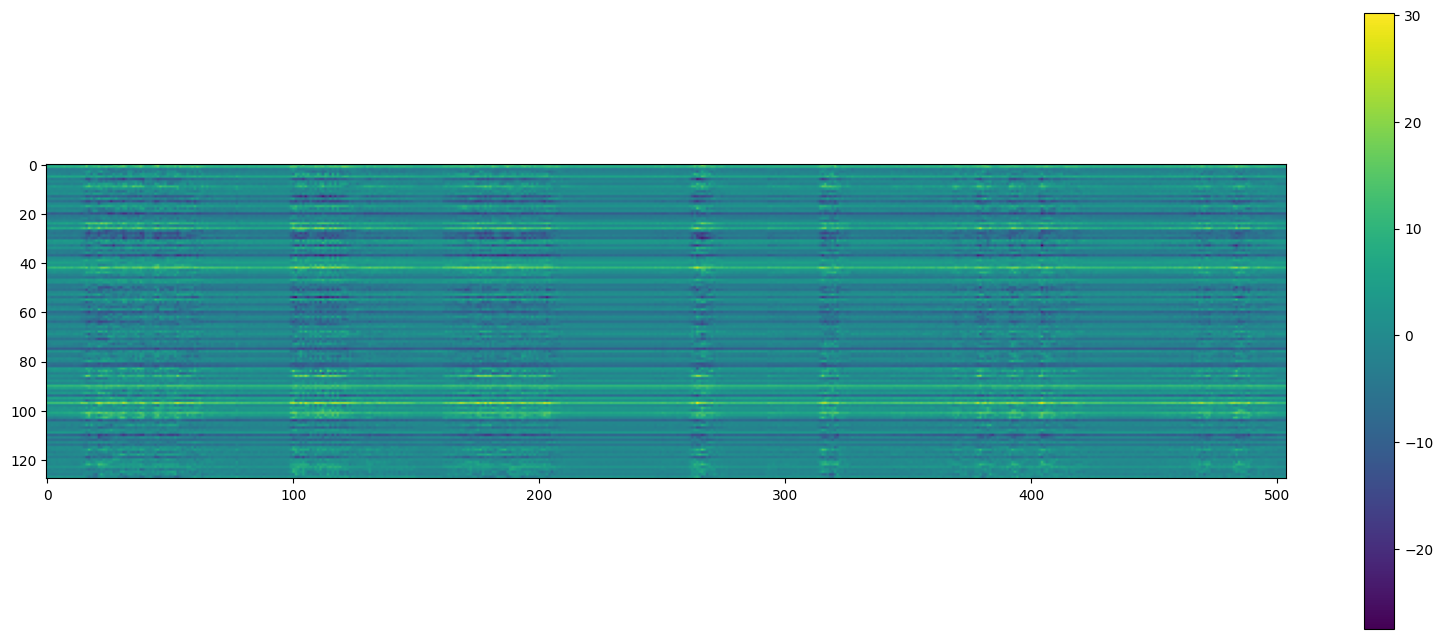

/u/li19/diffusers_with_dataloader/notebooks/imgs/endcoder_latent--5rnGk2e1ao.png

min val:-27.509296417236328
max val:30.203044891357422
mean:-0.498193621635437
std:5.379598617553711


In [168]:
# print(real_latent)
plt.figure(figsize=(20,8))
plt.imshow(real_encoder_latent.detach().cpu().numpy()[0])
filename = f'imgs/endcoder_latent-{youtube_id}.png'
plt.savefig(filename)
plt.colorbar()

plt.show()
plt.close()
display(FileLink(filename))
print(f'min val:{real_encoder_latent.detach().cpu().numpy()[0].min()}')
print(f'max val:{real_encoder_latent.detach().cpu().numpy()[0].max()}')

print(f'mean:{real_encoder_latent.detach().cpu().numpy()[0].mean()}')
print(f'std:{real_encoder_latent.detach().cpu().numpy()[0].std()}')

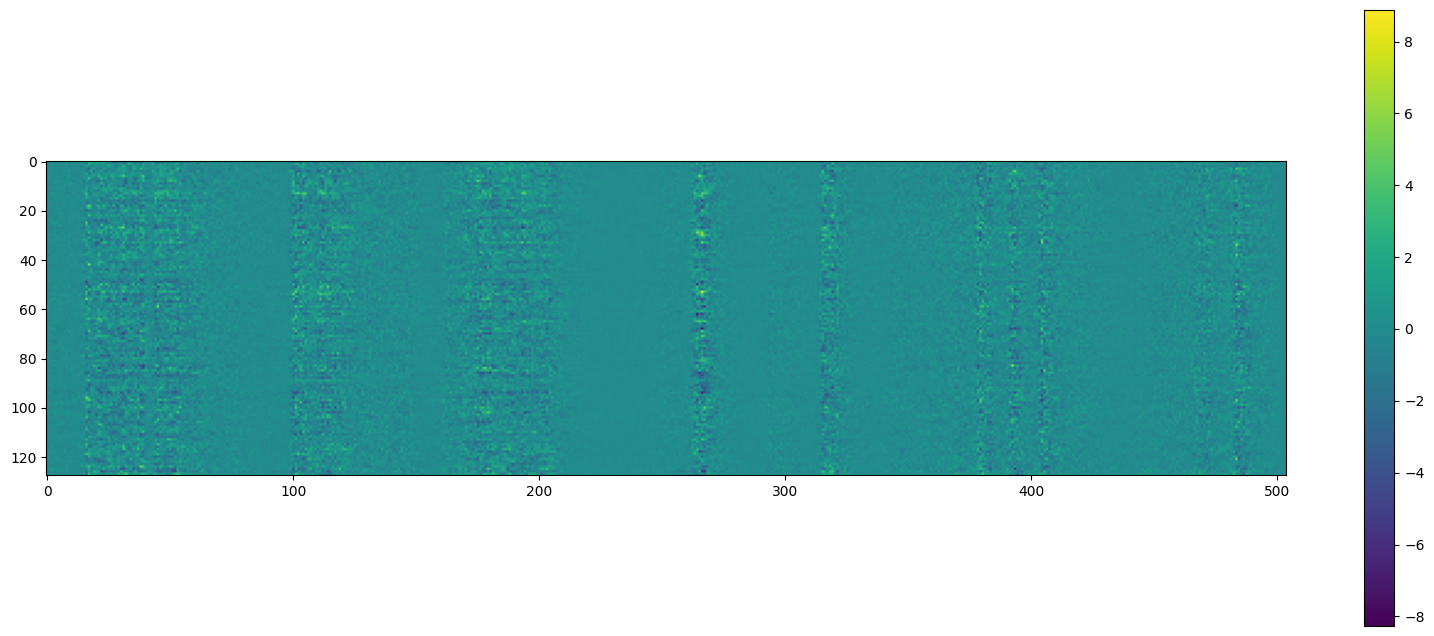

/u/li19/diffusers_with_dataloader/notebooks/imgs/endcoder_latent--5rnGk2e1ao.png

min val:-8.267910957336426
max val:8.878815650939941
mean:0.005279964301735163
std:0.8194825053215027


In [169]:
encodec_diff = pre_decode - real_encoder_latent
# print(encodec_diff.sum(dim=1))
# print(encodec_diff.mean(dim=1))
plt.figure(figsize=(20,8))
plt.imshow(encodec_diff.detach().cpu().numpy()[0])
filename = f'imgs/endcoder_latent-{youtube_id}.png'
plt.savefig(filename)
plt.colorbar()

plt.show()
plt.close()
display(FileLink(filename))
print(f'min val:{encodec_diff.detach().cpu().numpy()[0].min()}')
print(f'max val:{encodec_diff.detach().cpu().numpy()[0].max()}')

print(f'mean:{encodec_diff.detach().cpu().numpy()[0].mean()}')
print(f'std:{encodec_diff.detach().cpu().numpy()[0].std()}')

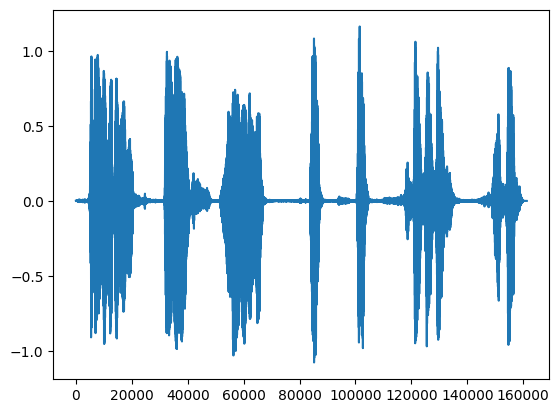

In [170]:
plt.plot(final)
ipd.Audio(final, rate=16_000)

torch.Size([1, 128, 504])


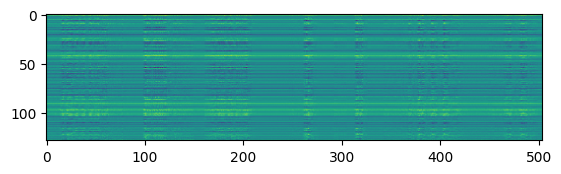

In [171]:
print(pre_decode.shape)
plt.imshow(pre_decode.detach().cpu()[0])

In [172]:
n_fft = 4096
win_length = 1024
hop_length = 400
n_mels = 64
sample_rate = 16000

waveform = torch.from_numpy(np.copy(final)[None, :])
waveform_orgin = wav.detach().cpu()
print(waveform.shape)

mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="constant",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="slaney",
)

# From latent file in dataset
mel_spectrogram = mel_spectrogram_transform(waveform)
amplitude_to_db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=88)
log_mel_spectrogram_db = amplitude_to_db_transform(mel_spectrogram)


# From wav file
mel_spectrogram_orig = mel_spectrogram_transform(waveform_orgin)
log_mel_spectrogram_db_orig = amplitude_to_db_transform(mel_spectrogram_orig)
# log_mel_spectrogram_db = log_mel_spectrogram_db.transpose(0,1)

torch.Size([1, 161280])


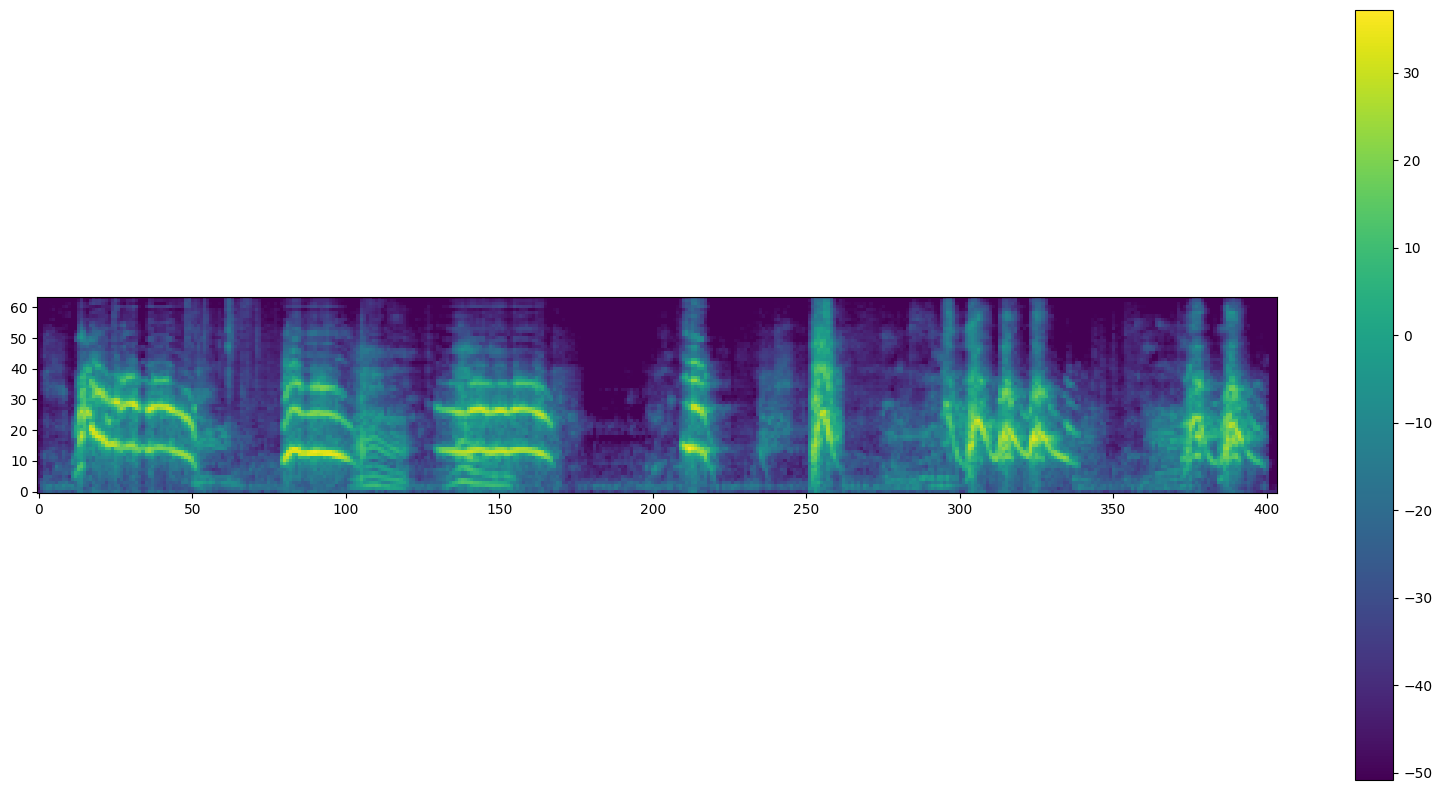

/u/li19/diffusers_with_dataloader/notebooks/imgs/regen_pre-spec--5rnGk2e1ao.png

In [173]:
# Set the figure size
fig= plt.figure(figsize=(20, 10))
# Show the image
plt.imshow(log_mel_spectrogram_db[0], origin='lower')
filename = f'imgs/regen_{pre_post_flag}-spec-{youtube_id}.png'
plt.savefig(filename)
plt.colorbar()
# Display the plot
plt.show()
plt.close()
display(FileLink(filename))



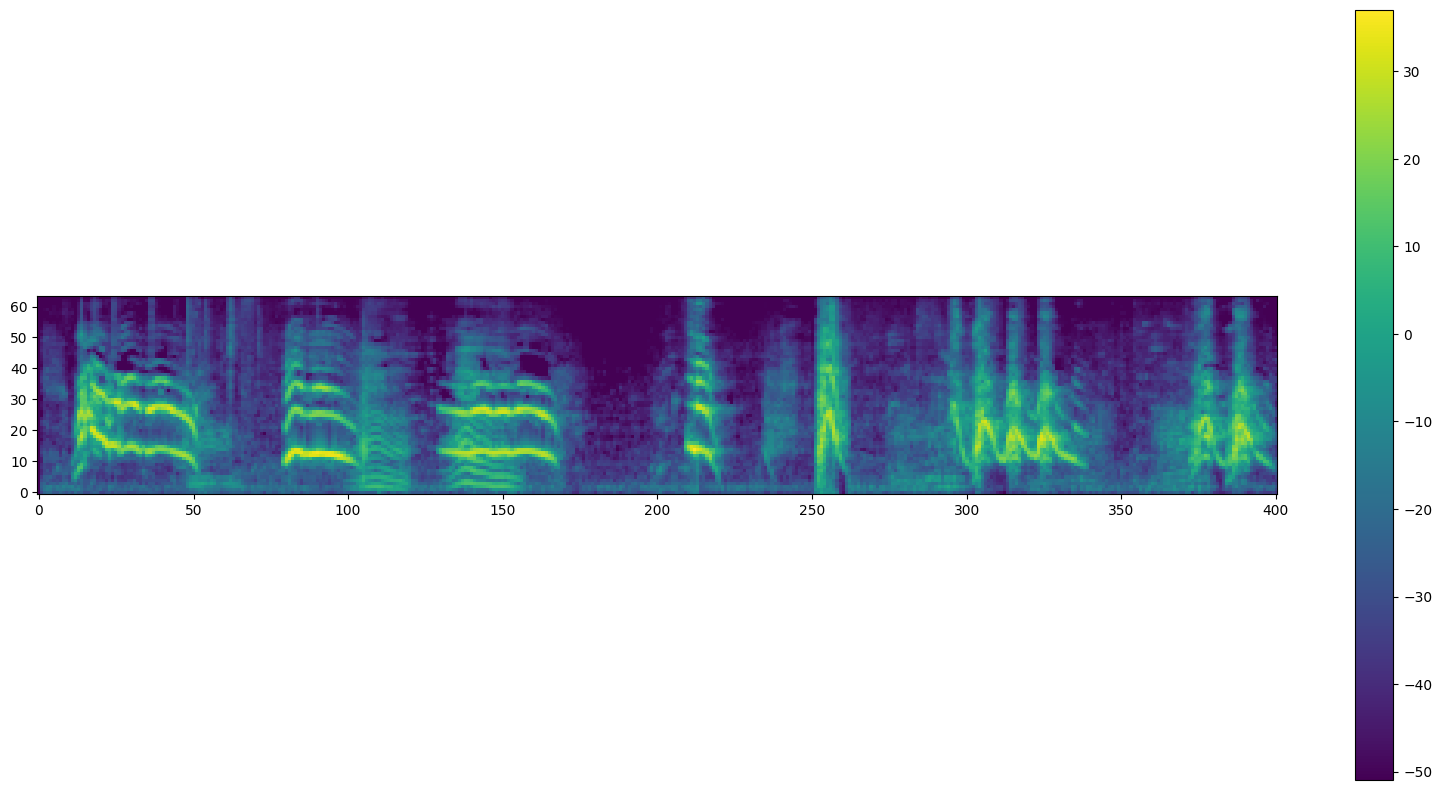

/u/li19/diffusers_with_dataloader/notebooks/imgs/origin_spec--5rnGk2e1ao.png

In [174]:
# Set the figure size
fig= plt.figure(figsize=(20, 10))
# Show the image
plt.imshow(log_mel_spectrogram_db_orig[0], origin='lower')
filename = f'imgs/origin_spec-{youtube_id}.png'
plt.savefig(filename)
plt.colorbar()
# Display the plot
plt.show()
plt.close()
display(FileLink(filename))